In [2]:
#%pip install yfinance
#%pip install pmdarima

In [3]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pmdarima as pm

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data_hour = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_15_minute, n_bars=4000)

# Display the last five rows
prices = forex_data_hour['close']
prices

datetime
2024-08-27 04:30:00    2511.85
2024-08-27 04:45:00    2509.74
2024-08-27 05:00:00    2506.78
2024-08-27 05:15:00    2507.01
2024-08-27 05:30:00    2507.12
                        ...   
2024-10-25 16:30:00    2729.98
2024-10-25 16:45:00    2727.76
2024-10-25 17:00:00    2737.75
2024-10-25 17:15:00    2734.96
2024-10-25 17:30:00    2736.99
Name: close, Length: 4000, dtype: float64

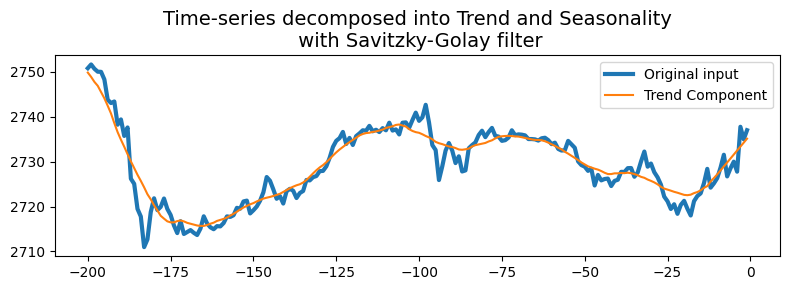

In [4]:
# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

yvalues = prices
yvalues_trend = savgol_filter(yvalues,19,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-200,0), yvalues[-200:], label='Original input',linewidth=3)
ax.plot(np.arange(-200,0), yvalues_trend[-200:], label='Trend Component')
#ax.plot(yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()


In [5]:
# Definition of Forecast Parameters
validation_elements = 0
forecast_elements = 40

# Trend - fit stepwise auto-ARIMA
smodel = pm.auto_arima(yvalues_trend, start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4,
                         start_P=0, seasonal=False,
                         d=None, D=0, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
smodel.summary()

forecast = smodel.predict(n_periods=forecast_elements)

# Extend trend forecast
yvalues_trend_forecast = np.concatenate((yvalues_trend, forecast))
print(yvalues_trend_forecast[-forecast_elements:])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3601.934, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4836.118, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3596.403, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1099.429, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4899.798, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3631.406, Time=1.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3602.487, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3624.583, Time=1.85 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3603.816, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3604.828, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3605.112, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3598.163, Time=1.89 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3629.333, Time=0.99 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 8.611 seconds
[2735.927379

In [6]:
def fft_forecast(signal, forecast_elements, target_harmonics=40):

    # Perform FFT on the seasonal component
    N = len(signal)
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(N)

    # **2. Retain non-negative frequencies (including zero)**
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]

    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]

    # **3. Create extended indices including future points**
    reconstructed_length = N + forecast_elements
    extended_indices = np.arange(reconstructed_length)

    # **4. Reconstruct the signal using the selected harmonics**
    reconstructed_signal = np.zeros(reconstructed_length)

    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency

        if frequency == 0:  # DC component
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    return reconstructed_signal, num_harmonics

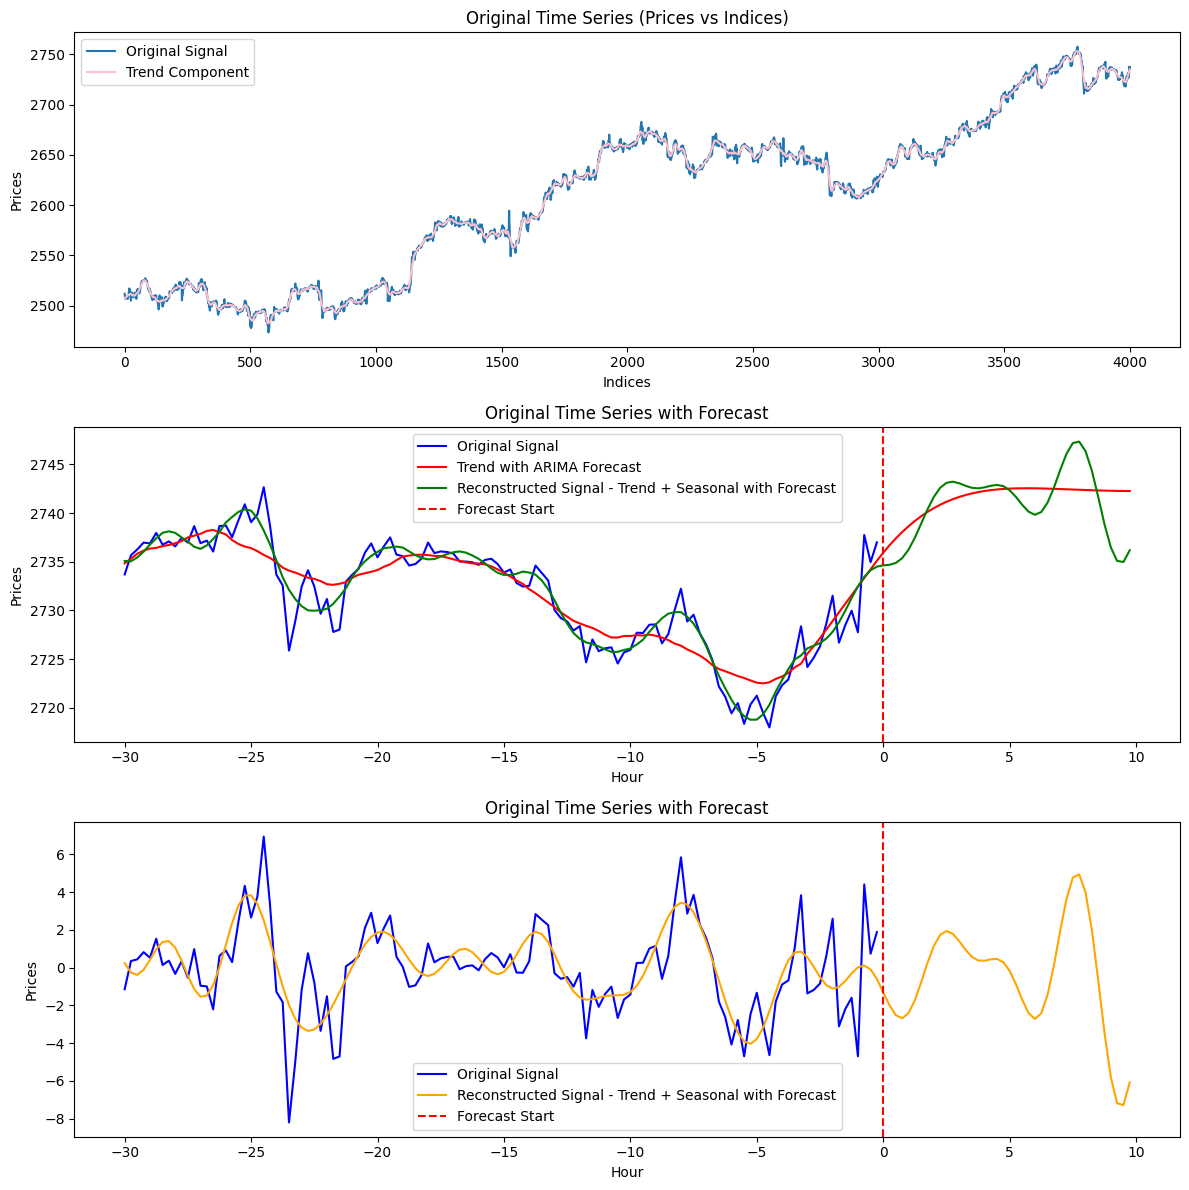

In [7]:
seasonal_input_elements = 598
visualization_elements = 120
seasonal_harmonics = 60

# 1. Correctly select the latest seasonal_input_elements

yvalues_seasonal_forecast, num_harmonics = fft_forecast(yvalues_seasonal[-seasonal_input_elements:], forecast_elements, seasonal_harmonics)
# Plot

# Adjust data slices to match combined_indices length
prices_slice = prices[-visualization_elements:]
trend_slice = yvalues_trend_forecast[-(visualization_elements+forecast_elements):]
seasonal_slice = yvalues_seasonal_forecast[-(visualization_elements+forecast_elements):]

# **6b. Plotting**
plt.figure(figsize=(12, 12))

# Plot original signal and trend
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(prices)), prices, label="Original Signal")
plt.plot(np.arange(len(yvalues_trend)), yvalues_trend, label='Trend Component', color='pink')
plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot combined trend and seasonal with forecast
plt.subplot(3, 1, 2)
plt.plot(np.arange(-visualization_elements,0)/4, prices_slice, label="Original Signal", color='blue')
plt.plot(np.arange(-visualization_elements,forecast_elements)/4, trend_slice, label="Trend with ARIMA Forecast", color='red')
plt.plot(np.arange(-visualization_elements,forecast_elements)/4, trend_slice+seasonal_slice, label="Reconstructed Signal - Trend + Seasonal with Forecast", color='green')
plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
plt.title("Original Time Series with Forecast")
plt.xlabel("Hour")
plt.ylabel("Prices")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.arange(-visualization_elements,0)/4, prices_slice-trend_slice[:-forecast_elements], label="Original Signa - Trend", color='blue')
plt.plot(np.arange(-visualization_elements,forecast_elements)/4, seasonal_slice, label="Reconstructed Signal - Trend + Seasonal with Forecast", color='orange')
plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
plt.title("Seasonal Time Series with Forecast")
plt.xlabel("Hour")
plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
import tkinter as tk
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np

class InteractivePlot:
    def __init__(self, yvalues_seasonal, yvalues_trend_forecast, prices, 
                 forecast_elements, visualization_elements=120, initial_harmonics=60):
        self.yvalues_seasonal = yvalues_seasonal
        self.yvalues_trend_forecast = yvalues_trend_forecast
        self.prices = prices
        self.forecast_elements = forecast_elements
        self.visualization_elements = visualization_elements
        self.seasonal_input = 598  # Initial value
        self.seasonal_harmonics = initial_harmonics
        
        # Create main window
        self.root = tk.Tk()
        self.root.title("Interactive FFT Plot")
        
        # Create control panel
        control_panel = tk.Frame(self.root)
        control_panel.pack(side=tk.TOP, pady=10)
        
        # Seasonal Input Controls
        seasonal_frame = tk.LabelFrame(control_panel, text="Seasonal Input", padx=10, pady=5)
        seasonal_frame.pack(side=tk.LEFT, padx=20)
        
        tk.Button(seasonal_frame, text="▲", command=self.increment_seasonal,
                 font=('Arial', 16), width=3).pack(pady=2)
        self.seasonal_label = tk.Label(seasonal_frame, 
                                     text=str(self.seasonal_input),
                                     font=('Arial', 12))
        self.seasonal_label.pack(pady=2)
        tk.Button(seasonal_frame, text="▼", command=self.decrement_seasonal,
                 font=('Arial', 16), width=3).pack(pady=2)
        
        # Harmonics Controls
        harmonics_frame = tk.LabelFrame(control_panel, text="Harmonics", padx=10, pady=5)
        harmonics_frame.pack(side=tk.LEFT, padx=20)
        
        tk.Button(harmonics_frame, text="▲", command=self.increment_harmonics,
                 font=('Arial', 16), width=3).pack(pady=2)
        self.harmonics_label = tk.Label(harmonics_frame, 
                                      text=str(self.seasonal_harmonics),
                                      font=('Arial', 12))
        self.harmonics_label.pack(pady=2)
        tk.Button(harmonics_frame, text="▼", command=self.decrement_harmonics,
                 font=('Arial', 16), width=3).pack(pady=2)
        
        # Create figure and canvas
        self.fig = Figure(figsize=(12, 8))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Initial plot
        self.update_plot()
        
    def update_plot(self):
        self.fig.clear()
        
        # Calculate new forecast
        yvalues_seasonal_forecast, num_harmonics = fft_forecast(
            self.yvalues_seasonal[-self.seasonal_input:], 
            self.forecast_elements, 
            self.seasonal_harmonics
        )
        
        # Adjust data slices
        prices_slice = self.prices[-self.visualization_elements:]
        trend_slice = self.yvalues_trend_forecast[-(self.visualization_elements+self.forecast_elements):]
        seasonal_slice = yvalues_seasonal_forecast[-(self.visualization_elements+self.forecast_elements):]
        
        # Create plot
        ax = self.fig.add_subplot(111)
        ax.plot(np.arange(-self.visualization_elements,0)/4, 
                prices_slice-trend_slice[:-self.forecast_elements], 
                label="Original Signal", color='blue')
        ax.plot(np.arange(-self.visualization_elements,self.forecast_elements)/4, 
                seasonal_slice, 
                label="Reconstructed Signal - Trend + Seasonal with Forecast", 
                color='orange')
        ax.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
        ax.set_title(f"Original Time Series with Forecast\nSeasonal Input: {self.seasonal_input}, Harmonics: {self.seasonal_harmonics}")
        ax.set_xlabel("Hour")
        ax.set_ylabel("Prices")
        ax.legend()
        
        self.fig.tight_layout()
        self.canvas.draw()
        
        # Update labels
        self.seasonal_label.config(text=str(self.seasonal_input))
        self.harmonics_label.config(text=str(self.seasonal_harmonics))
    
    def increment_seasonal(self):
        self.seasonal_input += 1
        self.update_plot()
        
    def decrement_seasonal(self):
        self.seasonal_input -= 1
        self.update_plot()
        
    def increment_harmonics(self):
        self.seasonal_harmonics += 1
        self.update_plot()
        
    def decrement_harmonics(self):
        if self.seasonal_harmonics > 1:  # Prevent negative harmonics
            self.seasonal_harmonics -= 1
            self.update_plot()
    
    def run(self):
        self.root.mainloop()

# Create and run the interactive plot
plotter = InteractivePlot(yvalues_seasonal, yvalues_trend_forecast, prices, 
                         forecast_elements)
plotter.run()